neccessary imports, setting the compute device, setting seed, loading the network and scalers

In [22]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import os 
import random
import torch 
import pickle
import optuna 

## user inputs ## 
# names and directories 
model_name = "forward_MLP.pth" 
scaler_model_dir_name = "network_data"  
input_scaler_filename = "input_scaler.pkl" 
state_scaler_filename = "state_scaler.pkl"
# neural network configuration  
lag_input = 0 
lag_state = 1
num_hidden_layers = 0
hidden_units = 30 
input_flat_size = 6 + (lag_state*6) + 3 + (lag_input*3) 
output_size = 6 
n_states = 6 
n_inputs = 3
# optimization parameters 
x_intial = np.array([3.3065416622541037e-06, 0, -0.19036912150652113, 6.0826336879046396e-06, 0, -0.3907576704717413])
X = np.tile(x_intial, (lag_state+1,1)) # handling the state lags
u_initial = np.array([0,0,0]) 
U = np.tile(u_initial, (lag_input+1, 1))  # handling the input lags
delta_umax = 12 # max change in inputs 
umax = 12 # max input 
tmax = 3  # max simulation time
dt = 0.1 # sampling time 
total_steps = int(tmax/dt) 
z_g = -1 # structure height 
g = 9.8 # gravity acceleration
des_land_pos = [0.15, 0.15] # desired landing pose 
Q = 1 # landing pose weight term  
n_trials = 1000 # number of trials

# selecting the compute device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 
print(f"using compute device: {device}") 
if device.type == "cuda":
    print(f"GPU: {torch.cuda.get_device_name(0)}")   

# setting seeds 
def set_all_seeds(seed: int = 42):
    """
    sets the seeds for python, numpy, and pytoch (CPU & GPU) 
    """
    # python random module
    random.seed(seed)
    # numpy
    np.random.seed(seed)
    # pytorch
    torch.manual_seed(seed)
    # pytorch (GPU)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    print(f"Seeds set to {seed}") 

# defining the model 
class MLP_model(torch.nn.Module): 
    def __init__(self, input_flat_size:int, hidden_units:int, output_size:int, num_hidden_layers:int) :
        super().__init__()
        self.input_flat_size = input_flat_size 
        self.hidden_units = hidden_units 
        self.output_size = output_size 
        self.num_hidden_layers = num_hidden_layers 

        hidden_layers = [] 

        in_dimension = self.input_flat_size 

        self.input_layer = torch.nn.Linear(in_features=in_dimension, out_features=self.hidden_units) 
        
        for i in range(self.num_hidden_layers) : 
            hidden_layers.append(torch.nn.Linear(in_features=self.hidden_units, out_features=self.hidden_units)) 
            hidden_layers.append(torch.nn.ReLU()) 

        self.backbone = torch.nn.Sequential(*hidden_layers) 
        
        self.output_layer = torch.nn.Linear(in_features=self.hidden_units, out_features=self.output_size) 
 
        self.relu = torch.nn.ReLU()    

    def forward(self,x): 
        out = self.input_layer(x) 
        out = self.relu(out)
        out = self.backbone(out)  
        out = self.output_layer(out) 
        return out  

# instantiating an NN object 
forward_model = MLP_model(input_flat_size=input_flat_size, hidden_units=hidden_units, output_size=output_size, num_hidden_layers=num_hidden_layers) 

# loading the statedicts 
script_path = os.path.dirname(os.path.abspath(__file__)) if "__file__" in globals() else os.getcwd() 
model_data_path = os.path.join(script_path, scaler_model_dir_name) 
forward_model.load_state_dict(torch.load(os.path.join(model_data_path, model_name), weights_only=True)) 
forward_model = forward_model.to(device=device) 
forward_model.eval()  

# loading the scalers 
with open(os.path.join(model_data_path, input_scaler_filename), "rb") as file : 
    input_scaler = pickle.load(file) 
with open(os.path.join(model_data_path, state_scaler_filename), "rb") as file : 
    state_scaler = pickle.load(file)

using compute device: cpu


defining the objective function

In [ ]:
def objective(trial) : 

    # decision variables : 
    # actuator inputs 
    u1_step = trial.suggest_float("act1_step", 0, umax) # actuator 1 
    u2_step = trial.suggest_float("act2_step", 0, umax) # actuator 2
    u3_step = trial.suggest_float("act3_step", 0, umax) # actuator 3 
    u_step = np.array([u1_step, u2_step, u3_step]) # shape (,3)
    # smoothstep and release time step  
    ramp_steps = trial.suggest_int("ramp_steps", 2, total_steps) 
    release_step = trial.suggest_int("release_step", 0, ramp_steps) 

    # configuring the inputs :
    # creating the ramp profile 
    ramp_factor = np.linspace(0,1,ramp_steps)   
    ramp_factor = np.repeat(ramp_factor[:,None], n_inputs, axis=1) 
    # creating the ramp array 
    u_ramp = ramp_factor * u_step  
    # padding the remaining input array with the final hold value 
    hold_steps = total_steps - ramp_steps 
    if hold_steps > 0 : 
        u_hold = np.tile(u_step, (hold_steps,1)) 
        u_array = np.vstack((u_ramp, u_hold)) 
    else : 
        u_array = u_ramp

    # stacking zeros (crucial for the simulation) 
    max_lag = max(lag_input, lag_state)
    zeros = np.zeros((max_lag+1, 3)) 
    u_array = np.vstack((zeros, u_array)) 

    # scaling the input array, initial states and conversion to torch tensor  
    u_array_scaled = input_scaler.transform(u_array) 
    u_array_torch = torch.from_numpy(u_array_scaled).type(torch.float32) 
    X_init = state_scaler.transform(X) 
    X_init_scaled = torch.from_numpy(X_init).type(torch.float32) 

    # rollout (dynamics simulation) :
    # initial buffer 
    current_state = X_init_scaled[max_lag,:] 
    if lag_state == 0 : 
        past_state = X_init_scaled[max_lag:max_lag] 
    else : 
        past_state = X_init_scaled[max_lag-lag_state:max_lag,:] 
        past_state = torch.flatten(input=past_state) 
    current_input = u_array_torch[max_lag,:] 
    if lag_input == 0 : 
        past_input = u_array_torch[max_lag:max_lag,:]
    else : 
        past_input = u_array_torch[max_lag-lag_input:max_lag,:] 
        past_input = torch.flatten(input=past_input) 

    if past_state.size(dim=0) == 0 and past_input.size(dim=0) == 0 : 
        joined_features = torch.concatenate((current_state, current_input), dim=0) 
    elif past_state.size(dim=0) != 0 and past_input.size(dim=0) == 0 : 
        joined_features = torch.concatenate((current_state, past_state, current_input), dim=0)
    elif past_state.size(dim=0) == 0 and past_input.size(dim=0) != 0 : 
        joined_features = torch.concatenate((current_state, current_input, past_input), dim=0) 
    else : 
        joined_features = torch.concatenate((current_state, past_state, current_input, past_input), dim=0) 

    preds = []  

    # creating the zero tensor array to act as a buffer for the predicted states
    X_buffer = torch.zeros(max_lag+1+len(u_array_torch), 6)
    for i in range(max_lag+1) : 
        X_buffer[i,:] = X_init_scaled[i,:]

    with torch.inference_mode(): 
        for i in range(max_lag+1, len(u_array_torch)) : 
            pred = forward_model(joined_features.unsqueeze(0)) 
            pred = pred.squeeze(0) 

            preds.append(pred) 
            X_buffer[i,:] = pred

            # updating the buffer 
            current_state = pred
            if lag_state == 0 : 
                past_state = X_buffer[i:i] 
            else : 
                past_state = X_buffer[i-lag_state:i,:] 
                past_state = torch.flatten(input=past_state) 
            current_input = u_array_torch[i,:] 
            if lag_input == 0 : 
                past_input = u_array_torch[i:i,:]
            else : 
                past_input = u_array_torch[i-lag_input:i,:] 
                past_input = torch.flatten(input=past_input) 

            if past_state.size(dim=0) == 0 and past_input.size(dim=0) == 0 : 
                joined_features = torch.concatenate((current_state, current_input), dim=0) 
            elif past_state.size(dim=0) != 0 and past_input.size(dim=0) == 0 : 
                joined_features = torch.concatenate((current_state, past_state, current_input), dim=0)
            elif past_state.size(dim=0) == 0 and past_input.size(dim=0) != 0 : 
                joined_features = torch.concatenate((current_state, current_input, past_input), dim=0) 
            else : 
                joined_features = torch.concatenate((current_state, past_state, current_input, past_input), dim=0)
    
    preds_tensor = torch.stack(preds, dim=0) 
    preds_np = preds_tensor.numpy() 

    # unscaling the predictions (states corrresponding to the inputs)  
    preds_np = state_scaler.inverse_transform(preds_np) 

    # calculating the veloctiy  
    diff = np.diff(preds_np, axis=0) 
    velocities = np.vstack([np.zeros((1, 6)), diff / dt]) 

    # predicting the landing positions 
    delta_z = preds_np[:, -1] - z_g 
    sqrt_term = velocities[:,-1]**2 + (2 * g * delta_z)
    t_flight = (velocities[:,-1] + np.sqrt(sqrt_term)) / g 
    x_landing = preds_np[:,3] + velocities[:,3] * t_flight
    y_landing = preds_np[:,4] + velocities[:,4] * t_flight  

    # actual landing based on the release time 
    idx = min(release_step, len(x_landing) - 1)
    act_landing_x = x_landing[idx] 
    act_landing_y = y_landing[idx]
    land_pos = np.array([act_landing_x, act_landing_y]) 

    # distance to the goal 
    dist = np.linalg.norm(des_land_pos - land_pos) 

    cost = Q * dist 
    
    return cost

bayesian optimization settings and initiation

In [24]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=n_trials, show_progress_bar=True) 

[I 2026-01-26 14:34:02,676] A new study created in memory with name: no-name-12a85eb0-d357-4932-be5a-0e1d335a7947


  0%|          | 0/1000 [00:00<?, ?it/s]

[I 2026-01-26 14:34:02,762] Trial 0 finished with value: 0.22655134274661054 and parameters: {'act1_step': 7.644601711698609, 'act2_step': 7.510140367844658, 'act3_step': 4.210031804794166, 'ramp_steps': 28, 'release_step': 12}. Best is trial 0 with value: 0.22655134274661054.
[I 2026-01-26 14:34:02,786] Trial 1 finished with value: 0.18391480664863577 and parameters: {'act1_step': 6.624292304800661, 'act2_step': 5.448215140608507, 'act3_step': 10.285674044241283, 'ramp_steps': 15, 'release_step': 11}. Best is trial 1 with value: 0.18391480664863577.
[I 2026-01-26 14:34:02,827] Trial 2 finished with value: 0.2402170366667203 and parameters: {'act1_step': 2.102416143825815, 'act2_step': 7.514706801860886, 'act3_step': 0.5368838575224908, 'ramp_steps': 8, 'release_step': 4}. Best is trial 1 with value: 0.18391480664863577.
[I 2026-01-26 14:34:02,857] Trial 3 finished with value: 0.21547949361259142 and parameters: {'act1_step': 4.786502024006197, 'act2_step': 2.4598562248284765, 'act3_st

visualizing the trajectory 

Best Parameters Found:
  act1_step: 0.2637
  act2_step: 1.4225
  act3_step: 11.5651
  ramp_steps: 4.0000
  release_step: 3.0000

Best Objective Value (Cost): 0.0419
final distance:  0.041912261052759504


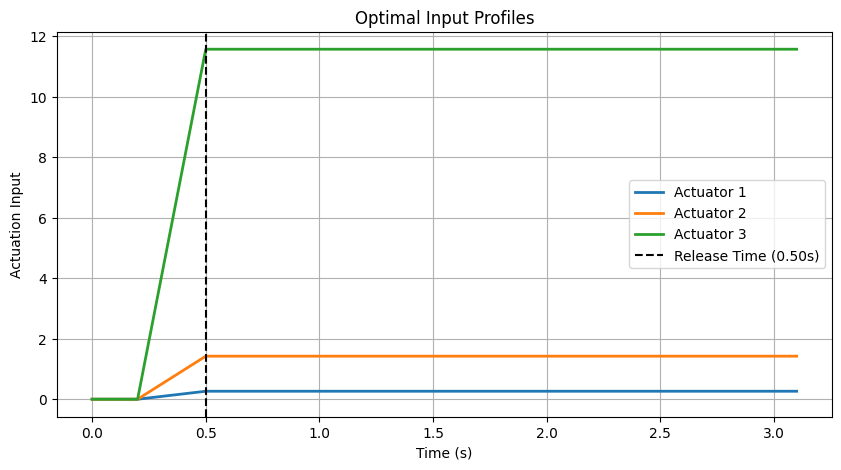

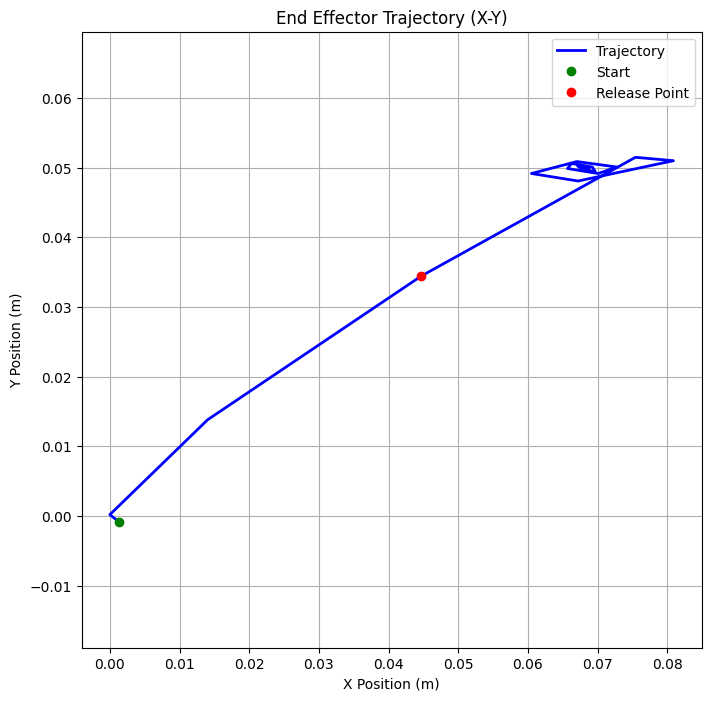

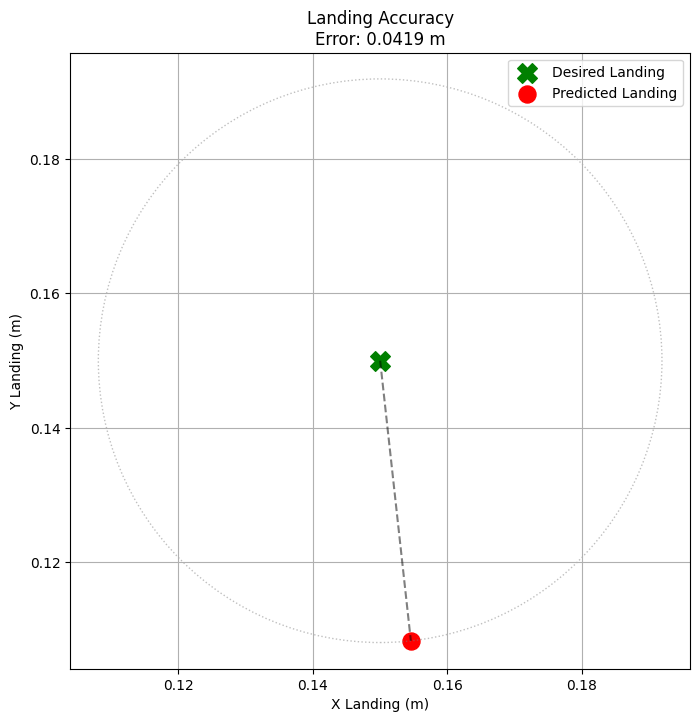

In [ ]:
import matplotlib.patches as patches

# extracting the best parameters
best_params = study.best_params
print("Best Parameters Found:")
for key, value in best_params.items():
    print(f"  {key}: {value:.4f}")
print(f"\nBest Objective Value (Cost): {study.best_value:.4f}")

# simulation using the best parameters
def run_simulation(params):
    # unpack params
    u1_step = params["act1_step"]
    u2_step = params["act2_step"]
    u3_step = params["act3_step"]
    u_step = np.array([u1_step, u2_step, u3_step])
    ramp_steps = params["ramp_steps"]
    release_step = params["release_step"]

    # configuring the inputs :
    # creating the ramp profile 
    ramp_factor = np.linspace(0,1,ramp_steps)   
    ramp_factor = np.repeat(ramp_factor[:,None], n_inputs, axis=1) 
    # creating the ramp array 
    u_ramp = ramp_factor * u_step  
    # padding the remaining input array with the final hold value 
    hold_steps = total_steps - ramp_steps 
    if hold_steps > 0 : 
        u_hold = np.tile(u_step, (hold_steps,1)) 
        u_array = np.vstack((u_ramp, u_hold)) 
    else : 
        u_array = u_ramp

    # stacking zeros (crucial for the simulation) 
    max_lag = max(lag_input, lag_state)
    zeros = np.zeros((max_lag+1, 3)) 
    u_array = np.vstack((zeros, u_array)) 

    # scaling the input array, initial states and conversion to torch tensor  
    u_array_scaled = input_scaler.transform(u_array) 
    u_array_torch = torch.from_numpy(u_array_scaled).type(torch.float32) 
    X_init = state_scaler.transform(X) 
    X_init_scaled = torch.from_numpy(X_init).type(torch.float32) 

    # rollout (dynamics simulation) :
    # initial buffer 
    current_state = X_init_scaled[max_lag,:] 
    if lag_state == 0 : 
        past_state = X_init_scaled[max_lag:max_lag] 
    else : 
        past_state = X_init_scaled[max_lag-lag_state:max_lag,:] 
        past_state = torch.flatten(input=past_state) 
    current_input = u_array_torch[max_lag,:] 
    if lag_input == 0 : 
        past_input = u_array_torch[max_lag:max_lag,:]
    else : 
        past_input = u_array_torch[max_lag-lag_input:max_lag,:] 
        past_input = torch.flatten(input=past_input) 

    if past_state.size(dim=0) == 0 and past_input.size(dim=0) == 0 : 
        joined_features = torch.concatenate((current_state, current_input), dim=0) 
    elif past_state.size(dim=0) != 0 and past_input.size(dim=0) == 0 : 
        joined_features = torch.concatenate((current_state, past_state, current_input), dim=0)
    elif past_state.size(dim=0) == 0 and past_input.size(dim=0) != 0 : 
        joined_features = torch.concatenate((current_state, current_input, past_input), dim=0) 
    else : 
        joined_features = torch.concatenate((current_state, past_state, current_input, past_input), dim=0) 

    preds = []  

    # creating the zero tensor array to act as a buffer for the predicted states
    X_buffer = torch.zeros(max_lag+1+len(u_array_torch), 6)
    for i in range(max_lag+1) : 
        X_buffer[i,:] = X_init_scaled[i,:]

    with torch.inference_mode(): 
        for i in range(max_lag+1, len(u_array_torch)) : 
            pred = forward_model(joined_features.unsqueeze(0)) 
            pred = pred.squeeze(0) 

            preds.append(pred) 
            X_buffer[i,:] = pred

            # updating the buffer 
            current_state = pred
            if lag_state == 0 : 
                past_state = X_buffer[i:i] 
            else : 
                past_state = X_buffer[i-lag_state:i,:] 
                past_state = torch.flatten(input=past_state) 
            current_input = u_array_torch[i,:] 
            if lag_input == 0 : 
                past_input = u_array_torch[i:i,:]
            else : 
                past_input = u_array_torch[i-lag_input:i,:] 
                past_input = torch.flatten(input=past_input) 

            if past_state.size(dim=0) == 0 and past_input.size(dim=0) == 0 : 
                joined_features = torch.concatenate((current_state, current_input), dim=0) 
            elif past_state.size(dim=0) != 0 and past_input.size(dim=0) == 0 : 
                joined_features = torch.concatenate((current_state, past_state, current_input), dim=0)
            elif past_state.size(dim=0) == 0 and past_input.size(dim=0) != 0 : 
                joined_features = torch.concatenate((current_state, current_input, past_input), dim=0) 
            else : 
                joined_features = torch.concatenate((current_state, past_state, current_input, past_input), dim=0)
    
    preds_tensor = torch.stack(preds, dim=0) 
    preds_np = preds_tensor.numpy() 

    # unscaling the predictions (states corrresponding to the inputs)  
    preds_np = state_scaler.inverse_transform(preds_np) 

    # calculating the veloctiy  
    diff = np.diff(preds_np, axis=0) 
    velocities = np.vstack([np.zeros((1, 6)), diff / dt]) 

    # predicting the landing positions 
    delta_z = preds_np[:, -1] - z_g 
    sqrt_term = velocities[:,-1]**2 + (2 * g * delta_z)
    t_flight = (velocities[:,-1] + np.sqrt(sqrt_term)) / g 
    x_landing = preds_np[:,3] + velocities[:,3] * t_flight
    y_landing = preds_np[:,4] + velocities[:,4] * t_flight  

    # actual landing based on the release time 
    idx = min(release_step, len(x_landing) - 1)
    act_landing_x = x_landing[idx] 
    act_landing_y = y_landing[idx]
    land_pos = np.array([act_landing_x, act_landing_y]) 

    # distance to the goal 
    dist = np.linalg.norm(des_land_pos - land_pos) 
    
    # Return data needed for plotting
    return u_array, preds_np, land_pos, release_step, dist

# Run the simulation
u_data, x_data, final_land_pos, release_idx, dist = run_simulation(best_params)
print("final distance: ", dist)

# Time vectors for plotting
time_steps = np.arange(len(x_data)) * dt
time_inputs = np.arange(len(u_data)) * dt

# plot 1: Actuation Profiles
plt.figure(figsize=(10, 5))
plt.plot(time_inputs, u_data[:, 0], label='Actuator 1', linewidth=2)
plt.plot(time_inputs, u_data[:, 1], label='Actuator 2', linewidth=2)
plt.plot(time_inputs, u_data[:, 2], label='Actuator 3', linewidth=2)
# Add vertical line for release time
# Note: release_idx corresponds to preds, we need to shift it for inputs which has lag padding
max_lag = max(lag_input, lag_state)
release_time_plot = (release_idx + max_lag + 1) * dt
plt.axvline(x=release_time_plot, color='k', linestyle='--', label=f'Release Time ({release_time_plot:.2f}s)')
plt.title('Optimal Input Profiles')
plt.xlabel('Time (s)')
plt.ylabel('Actuation Input')
plt.legend()
plt.grid(True)
plt.show()

# Plot 2: 2D End Effector Trajectory (X-Y)
plt.figure(figsize=(8, 8))
plt.plot(x_data[:, 3], x_data[:, 4], 'b-', linewidth=2, label='Trajectory')
# Mark start
plt.plot(x_data[0, 3], x_data[0, 4], 'go', label='Start')
# Mark release point
plt.plot(x_data[release_idx, 3], x_data[release_idx, 4], 'ro', label='Release Point')
plt.title('End Effector Trajectory (X-Y)')
plt.xlabel('X Position (m)')
plt.ylabel('Y Position (m)')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

# Plot 3: Landing Targets
plt.figure(figsize=(8, 8))
# Plot Desired
plt.scatter(des_land_pos[0], des_land_pos[1], color='green', s=200, marker='X', label='Desired Landing')
# Plot Actual
plt.scatter(final_land_pos[0], final_land_pos[1], color='red', s=150, marker='o', label='Predicted Landing')
# Draw line connecting them
plt.plot([des_land_pos[0], final_land_pos[0]], [des_land_pos[1], final_land_pos[1]], 'k--', alpha=0.5)

# Add circles for visual context (distance error)
error = np.linalg.norm(final_land_pos - des_land_pos)
circle = plt.Circle(des_land_pos, error, color='gray', fill=False, linestyle=':', alpha=0.5)
plt.gca().add_patch(circle)

plt.title(f'Landing Accuracy\nError: {error:.4f} m')
plt.xlabel('X Landing (m)')
plt.ylabel('Y Landing (m)')
plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()